## Exploratory Analysis

In [7]:
import pandas as pd
df = pd.read_csv("data/forecasts.csv")
# df = pd.read_csv("data/forecasts_hetero.csv")
# df = pd.read_csv("data/forecasts_hetero2.csv")
df.head()

,Quarter,Estimate Type,Predicted Value,Real Value,Company,Analyst,Bank,Market Cap,Sector,Start Date,Horizon,Revision Time
0,Q1 2013,Stock Price,2.651234e+01,3.127849e+01,Company5,Analyst513,JP Morgan,Mid Cap,Technology,2013-02-19,Q1,Initial
1,Q1 2013,Stock Price,2.928395e+01,3.127849e+01,Company5,Analyst513,Goldman Sachs,Mid Cap,Technology,2013-02-19,Q2,Initial
2,Q1 2013,EBITDA,1.551400e+09,1.226174e+09,Company5,Analyst513,Citi,Mid Cap,Technology,2013-02-19,Q0,Initial
3,Q1 2013,EBITDA,1.174947e+09,1.226174e+09,Company5,Analyst513,Morgan Stanley,Mid Cap,Technology,2013-02-19,Q1,Initial
4,Q1 2013,EBITDA,1.452862e+09,1.226174e+09,Company5,Analyst513,Citi,Mid Cap,Technology,2013-02-19,Q2,Initial


In [8]:
df.shape

(13826044, 12)

## Variables Explained

- **Quarter**: The target period for the forecast, defined by the calendar quarter‐end date. Formatted as `Q<quarter_number> <year>` (e.g. `Q1 2013` = the quarter ending in March 2013). This is the “anchor” date against which we judge each forecast’s accuracy. Think of `Quarter` as the quarter we're issuing forecasts from, and `Horizon` will be interpreted as  “how many quarters out I’m predicting.”
- **Estimate Type**: Which metric is being forecast (one of **Stock Price**, **EBITDA**, **EPS**, **Revenue**, **EBIT**).
- **Predicted Value**: The value the analyst predicts for the given **Estimate Type** and **Horizon**, at the point in time indicated by **Revision Time**.
- **Real Value** : The actual (simulated) value of the metric at the date when the horizon arrives. We populate this by looking up the true simulated path at the quarter‑end for Q0 forecasts, one quarter later for Q1, and two quarters later for Q2. Thus, the `Real Value` column has been filled in for that particular horizon, not for the anchor quarter itself.
- **Company**: Identifier for the company being forecast (e.g. `Company18`).
- **Analyst**: Identifier for the analyst who made the prediction (e.g. `Analyst27`).
- **Bank**: The institution the analyst is affiliated with (e.g. “JP Morgan”, “Goldman Sachs”).
- **Market Cap**: The company’s market‐cap category: **Large Cap**, **Mid Cap**, or **Small Cap**.
- **Sector**: The industry sector of the company (e.g. “Technology”, “Healthcare”).
- **Start Date**: The date the analyst began covering that company. No forecasts appear before this date.
- **Horizon**: How far into the future—relative to the **Quarter** anchor—the analyst is predicting:  
  - **Q0**: forecast _for_ the anchor quarter itself (now‑cast).  
  - **Q1**: one quarter _after_ the anchor.  
  - **Q2**: two quarters _after_ the anchor.  
  - *Example*: if `Quarter = Q2 2020` and `Horizon = Q1`, the target date is the end of Q3 2020.

- **Revision Time**: When the forecast was issued or updated.
  1. **Initial**  
     - The baseline estimate released _at_ the quarter‑end itself (immediately after Q0 actuals are known).  
  2. **Rev YYYY‑MM‑DD**  
     - Monthly “revision” points in the lead‑up to the quarter‑end, roughly 3, 2, and 1 months out.  
     - Formatted as `Rev YYYY‑MM‑DD` (e.g. `Rev 2013‑01‑31`, `Rev 2013‑02‑28`, `Rev 2013‑03‑29`).  
     - Allows us to see how forecasts evolve as new information arrives.

With this structure, for each `(Quarter, Horizon)` pair we can compare every analyst’s **Predicted Value** (at each **Revision Time**) to the **Real Value** once that horizon date has passed, enabling analysis of forecast bias, dispersion, and revision dynamics.

In [9]:
sample_rows = df.sample(n=5, random_state=42) # take 5 random rows with a fixed seed for reproducibility
sample_rows

,Quarter,Estimate Type,Predicted Value,Real Value,Company,Analyst,Bank,Market Cap,Sector,Start Date,Horizon,Revision Time
2214704,Q4 2016,Revenue,2.800996e+08,2.947899e+08,Company895,Analyst251,Goldman Sachs,Large Cap,Real Estate,2015-11-04,Q0,Initial
9420298,Q4 2020,EPS,1.638774e+01,1.576724e+01,Company319,Analyst125,Credit Suisse,Large Cap,Industrial,2015-02-09,Q1,Rev 2020-10-30
10251563,Q1 2021,EBITDA,1.825763e+09,1.842048e+09,Company938,Analyst205,Morgan Stanley,Mid Cap,Industrial,2014-04-21,Q2,Rev 2021-02-26
11772525,Q4 2021,EPS,1.092006e+01,8.470144e+00,Company185,Analyst31,Bank of America,Large Cap,Finance,2017-01-23,Q2,Rev 2021-10-29
12593582,Q1 2022,Revenue,3.048686e+10,3.083683e+10,Company691,Analyst668,Wells Fargo,Large Cap,Energy,2020-12-02,Q0,Rev 2022-02-28


## Interpretation

1. **Q4 2016 – Company895, Analyst251 (Goldman Sachs)**  
   On the _initial_ publication date, Analyst251 issued their now‑cast (Q0) for **Company895**’s **Q4 2016 Revenue** at **\$280.10 million**. When Q4 2016 actually closed, the true Revenue was **\$294.79 million**, so the forecast **underestimated** the realized value by about **4.9%**. Revision Time = Initial means “this is the analyst’s first published estimate for Q4 2016, issued right at the quarter close”. Because we treat Initial as just another forecast; it’s the very first time we publish the estimate at quarter‑end, before the numbers are officially released. In real life analysts often publish an estimate on the last trading day (or even after hours) before the company reports its earnings; those estimates can be off.

2. **Q4 2020 – Company319, Analyst125 (Credit Suisse)**  
   On **October 30 2020** (two months before the end of Q4 2020), Analyst125 updated their one‑quarter‑ahead forecast (Q1) for **Company319**’s **Q4 2020 EPS** to **\$16.39**. After Q1 2021 closed, the actual EPS was **\$15.77**, so the forecast **overshot** the realized value by about **3.9%**.

3. **Q1 2021 – Company938, Analyst205 (Morgan Stanley)**  
   On **February 26 2021** (one month before the end of Q1 2021), Analyst205 updated their two‑quarters‑ahead forecast (Q2) for **Company938**’s **Q1 2021 EBITDA** to **\$1.826 billion**. After Q3 2021 closed, the actual EBITDA was **\$1.842 billion**, so the forecast **underestimated** the realized value by about **0.9%**.

4. **Q4 2021 – Company185, Analyst31 (Bank of America)**  
   On **October 29 2021** (two months before the end of Q4 2021), Analyst31 updated their two‑quarters‑ahead forecast (Q2) for **Company185**’s **Q4 2021 EPS** to **\$10.92**. After Q2 2022 closed, the actual EPS was **\$8.47**, so the forecast **overshot** the realized value by about **28.9%**.

5. **Q1 2022 – Company691, Analyst668 (Wells Fargo)**  
   On **February 28 2022** (one month before the end of Q1 2022), Analyst668 updated their now‑cast (Q0) for **Company691**’s **Q1 2022 Revenue** to **\$30.49 billion**. After Q1 2022 closed, the actual Revenue was **\$30.84 billion**, so the forecast **underestimated** the realized value by about **1.1%**.

## Concrete Example: Q2 2019 Forecasts

Below is the full revision timeline for **Quarter = Q2 2019** (Apr–Jun 2019).  For each forecast we show the **Predicted Value**, but the **Real Value** only becomes known once that target quarter actually closes:

| Revision Time    | Calendar Date | Horizon | Target Period    | Predicted Value | Real Value | Meaning                                                           |
|------------------|---------------|:-------:|------------------|----------------:|-----------:|-------------------------------------------------------------------|
| **Rev 3 months** | 2019‑04‑01    | **Q0**  | Apr–Jun 2019     |           200.0 |      —      | First now‑cast (quarter in progress)                              |
|                  |               | **Q1**  | Jul–Sep 2019     |           210.0 |      —      | One‑quarter‑ahead forecast                                        |
|                  |               | **Q2**  | Oct–Dec 2019     |           220.0 |      —      | Two‑quarters‑ahead forecast                                       |
| **Rev 2 months** | 2019‑05‑01    | **Q0**  | Apr–Jun 2019     |           203.0 |      —      | Updated now‑cast                                                  |
|                  |               | **Q1**  | Jul–Sep 2019     |           208.0 |      —      | Updated next‑quarter forecast                                     |
|                  |               | **Q2**  | Oct–Dec 2019     |           218.0 |      —      | Updated two‑quarter forecast                                      |
| **Rev 1 month**  | 2019‑06‑01    | **Q0**  | Apr–Jun 2019     |           205.0 |      —      | Final now‑cast before quarter closes                              |
|                  |               | **Q1**  | Jul–Sep 2019     |           212.0 |      —      | Final next‑quarter forecast                                       |
|                  |               | **Q2**  | Oct–Dec 2019     |           215.0 |      —      | Final two‑quarter forecast                                        |
| **Initial**      | 2019‑06‑28    | **Q0**  | Apr–Jun 2019     |           207.0 |     205.0  | First published at quarter close (now‑cast vs. actual)            |
|                  |               | **Q1**  | Jul–Sep 2019     |           214.0 |      —      | First‐published 1‑quarter‐ahead forecast (actual known 9/30/19)   |
|                  |               | **Q2**  | Oct–Dec 2019     |           219.0 |      —      | First‐published 2‑quarter‐ahead forecast (actual known 12/31/19)  |

- **Predicted Value**: the analyst’s estimate at that revision & horizon.  
- **Real Value**:  
  - For **Q0** forecasts, the actual becomes known *immediately* after quarter‑end (we show it only at **Initial**).  
  - For **Q1** it becomes available when Q3 2019 closes (Sept 30 2019).  
  - For **Q2** it becomes available when Q4 2019 closes (Dec 31 2019).  
- **Blank (“—”)** indicates the real number was not yet available at that revision point.

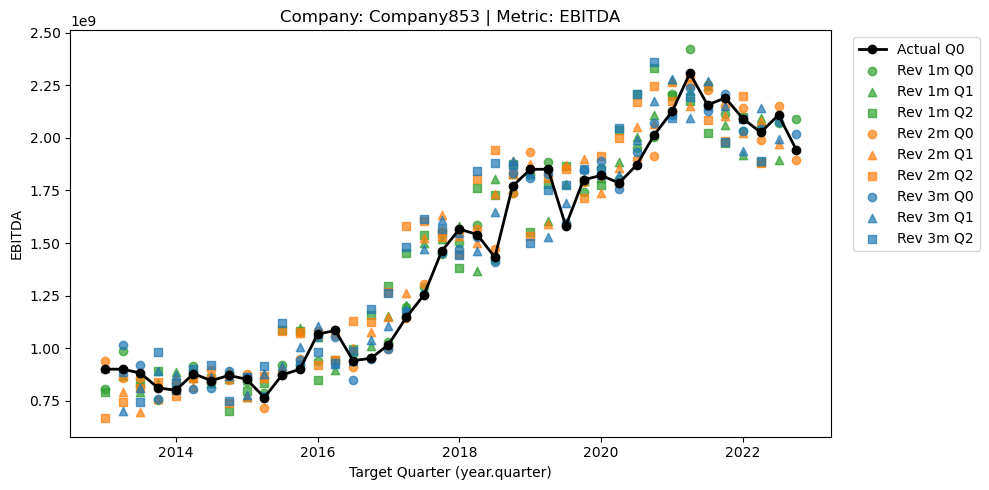

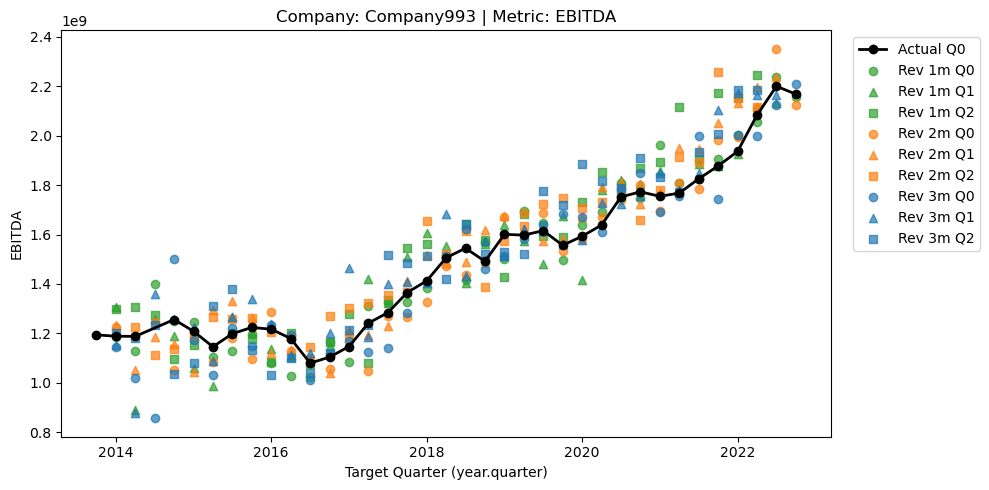

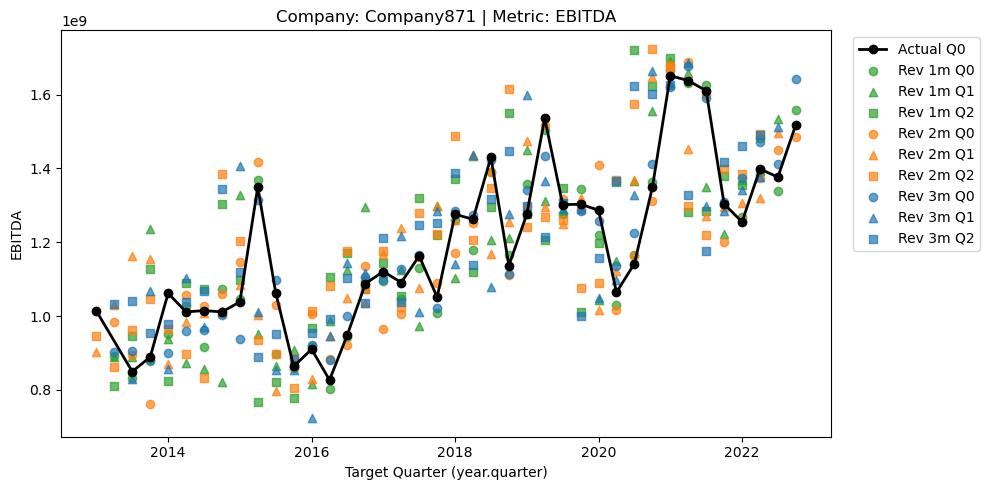

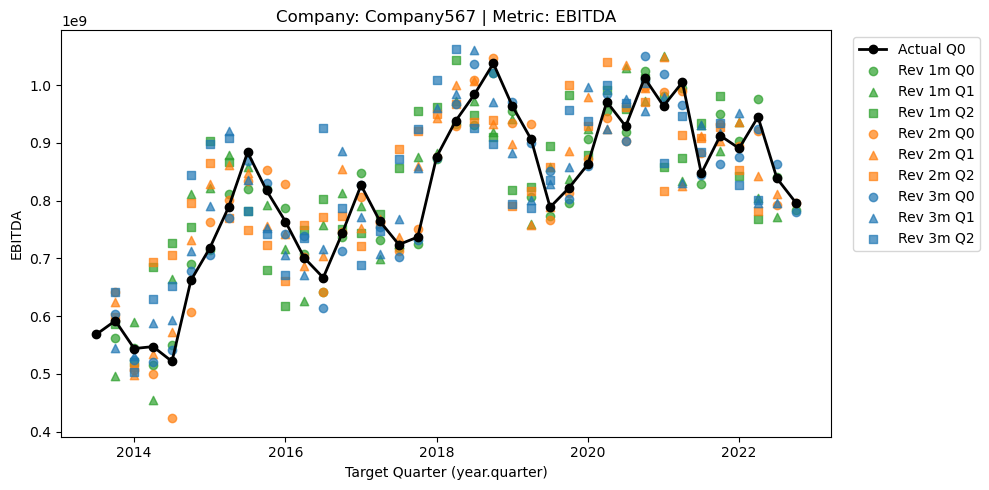

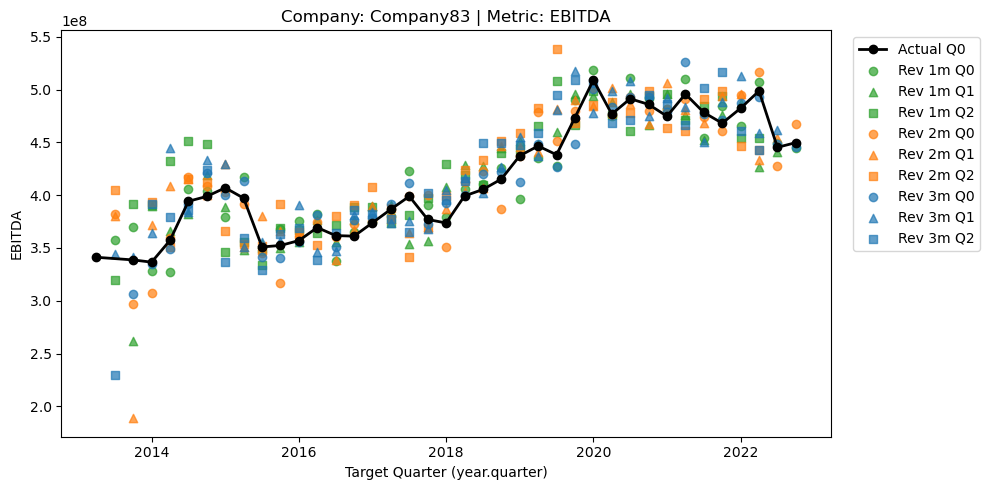

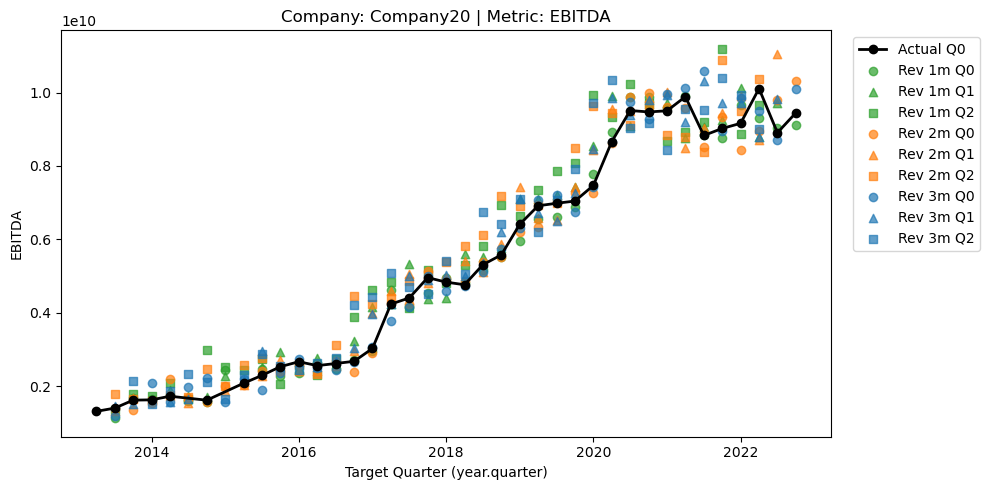

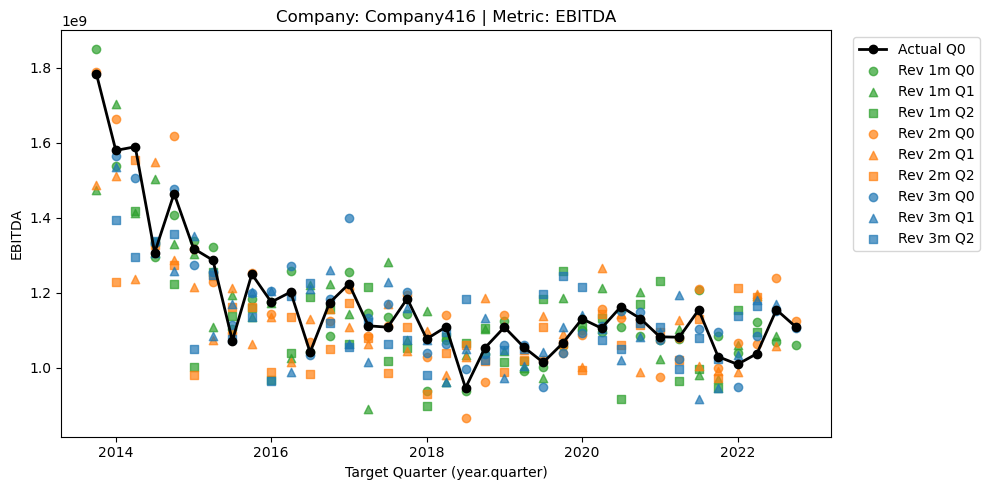

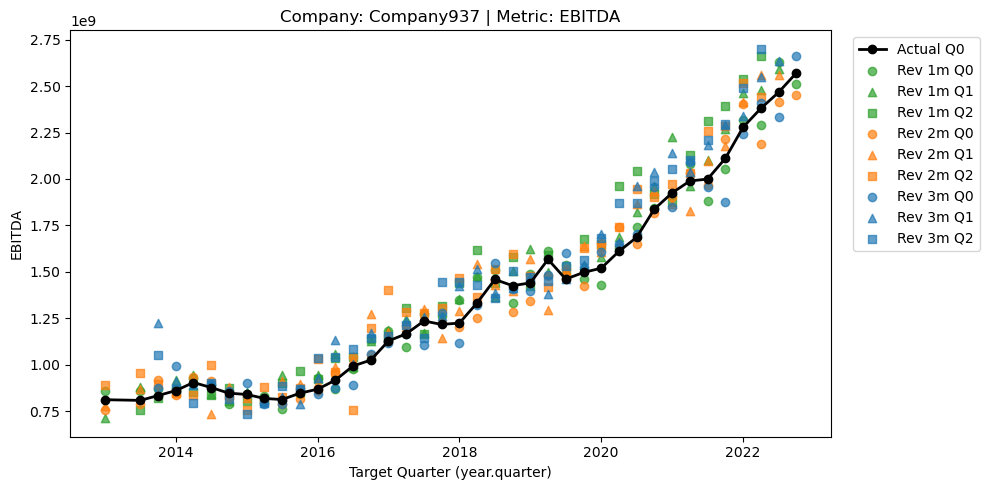

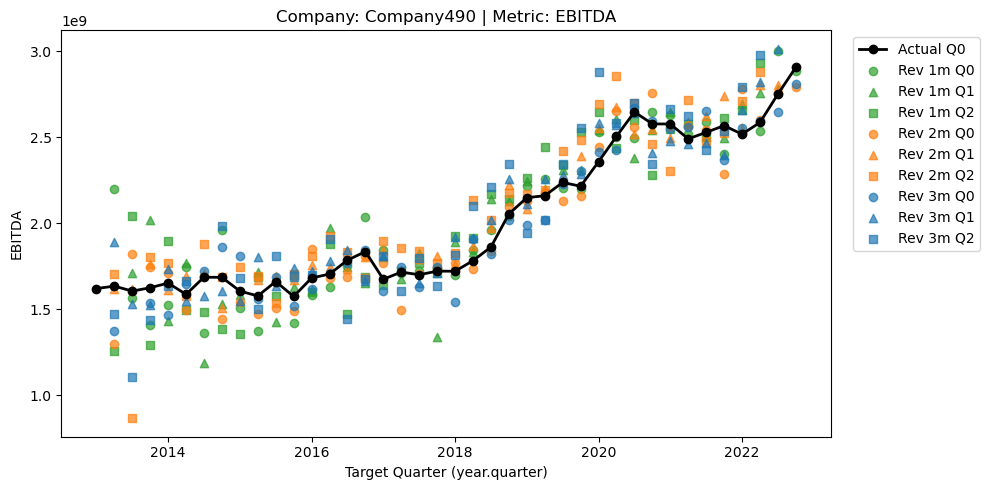

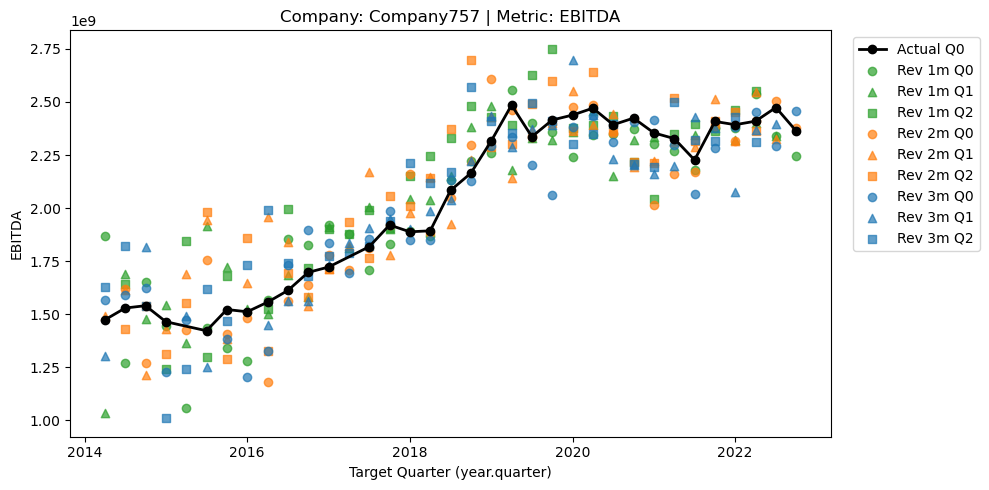

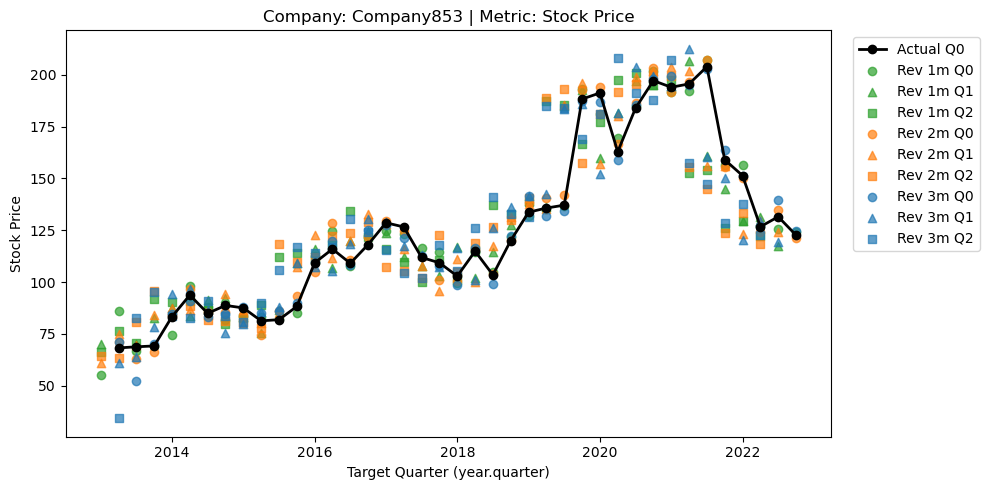

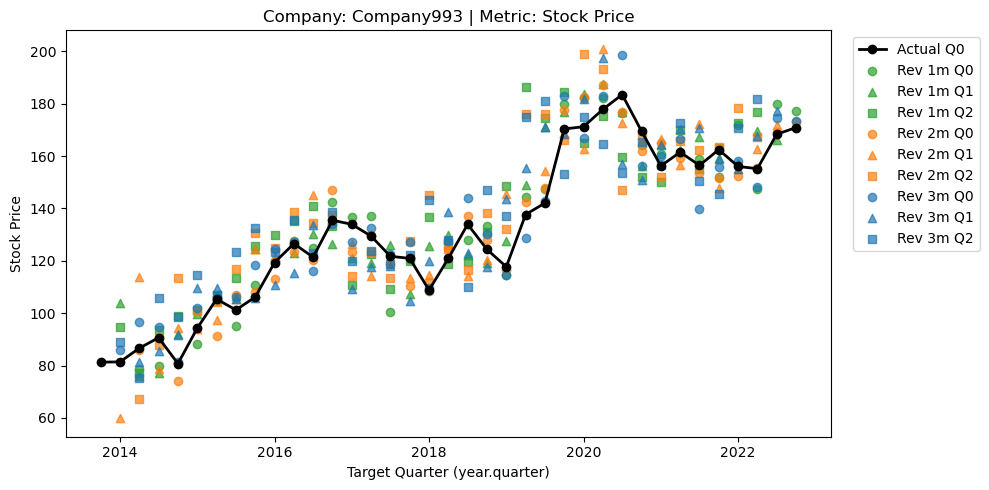

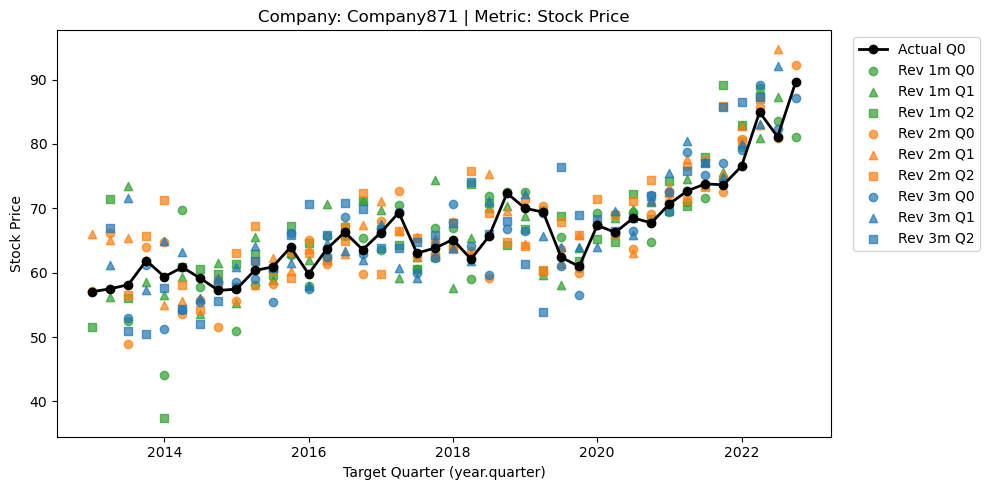

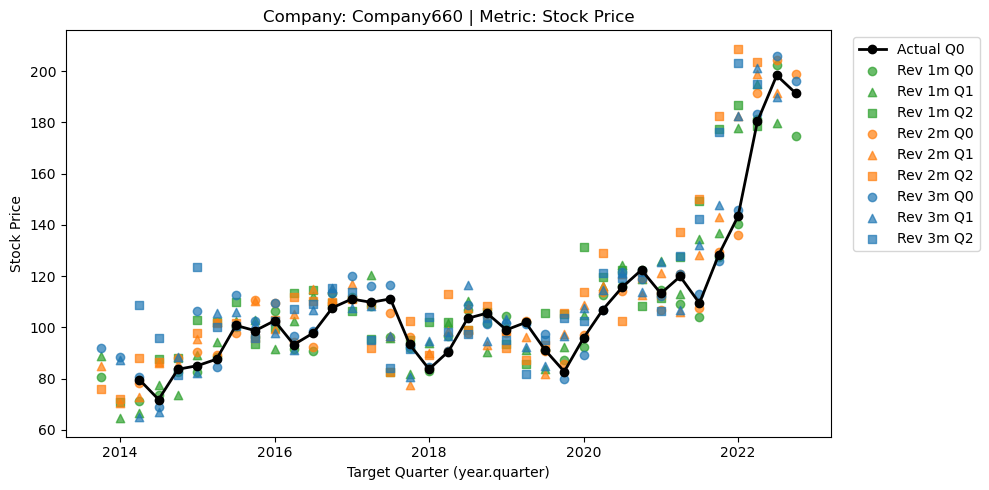

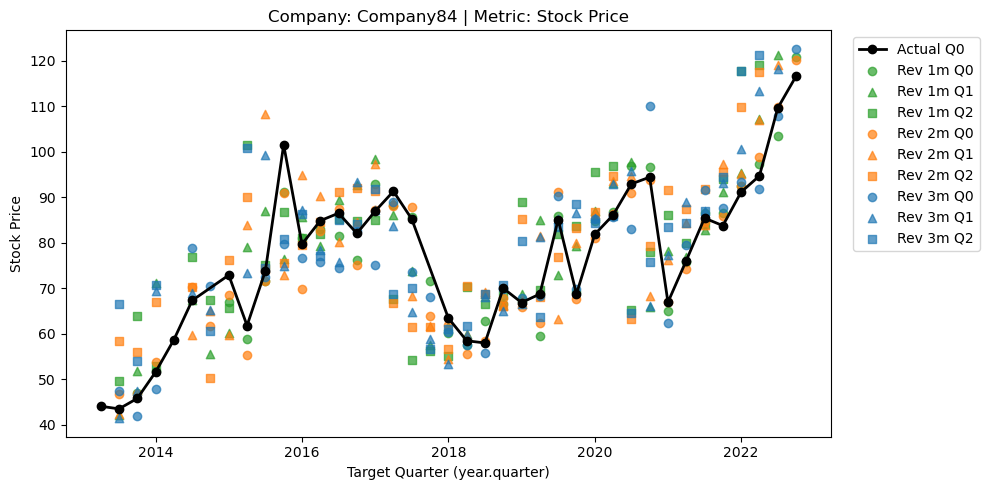

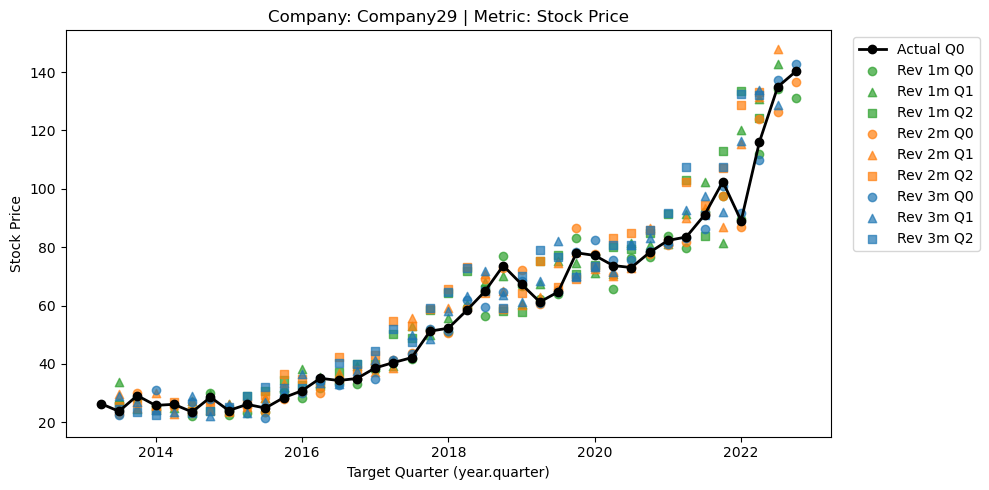

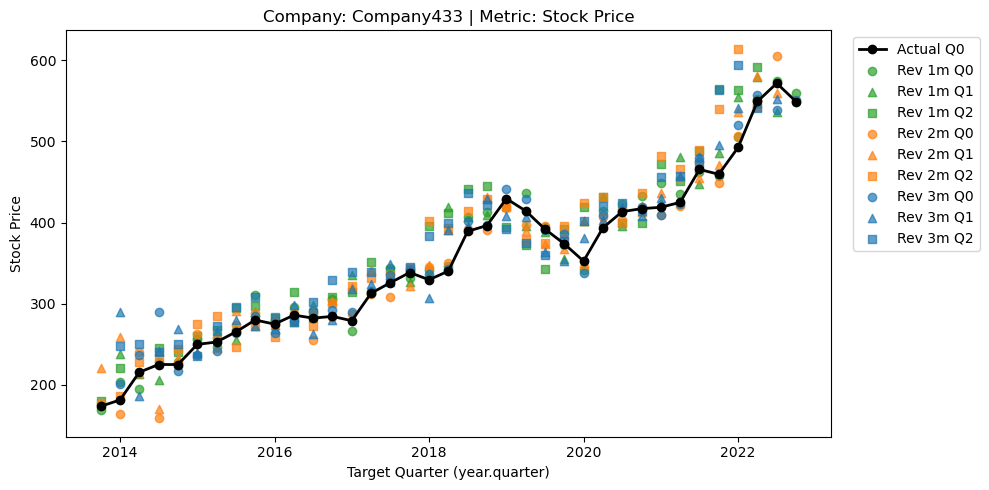

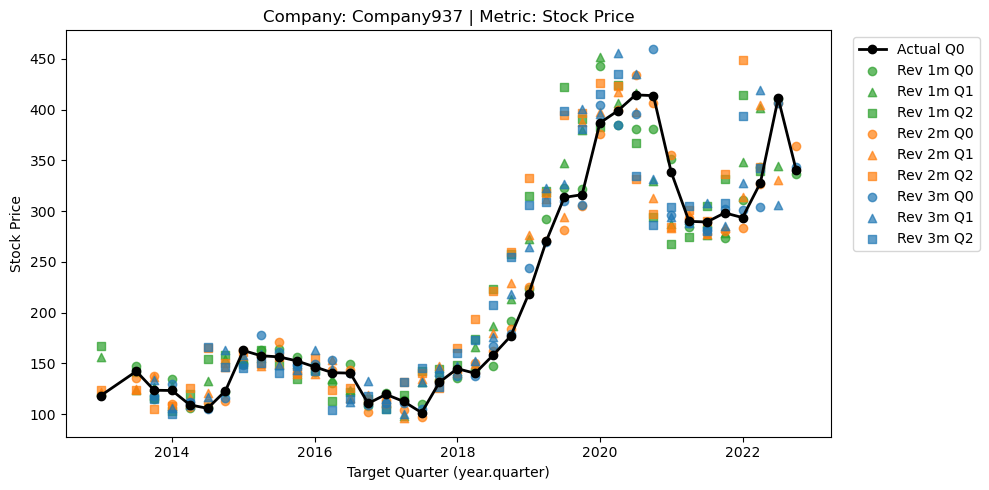

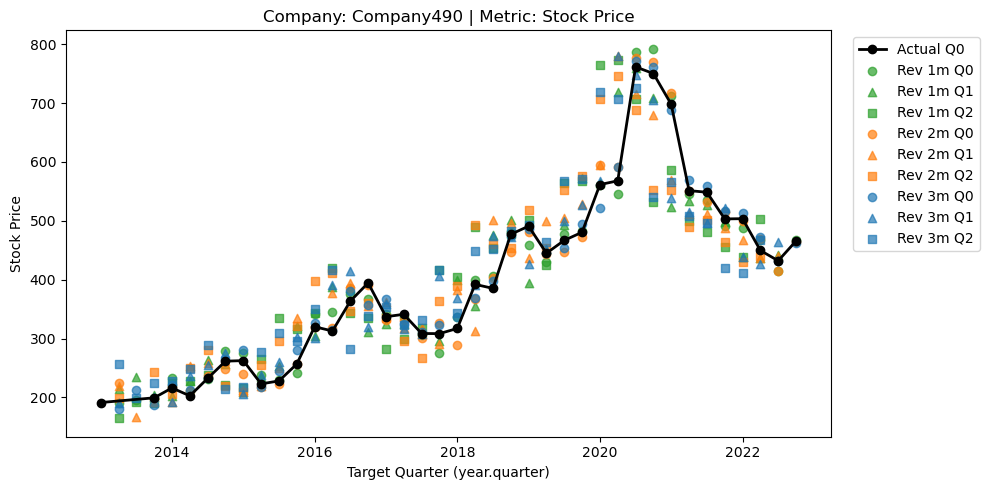

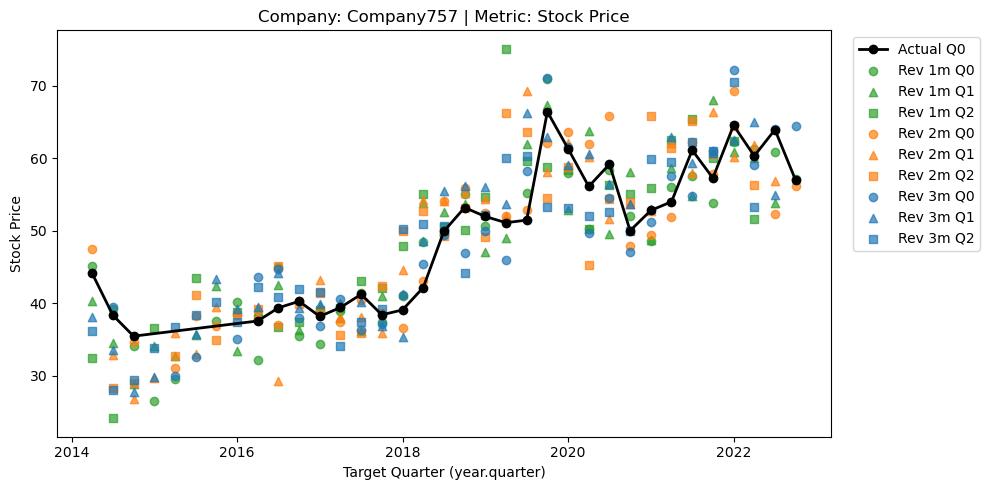

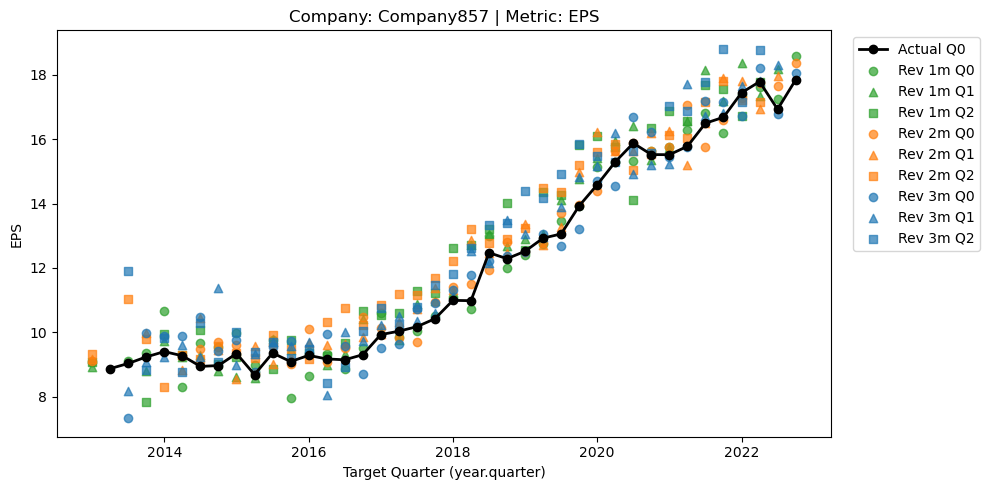

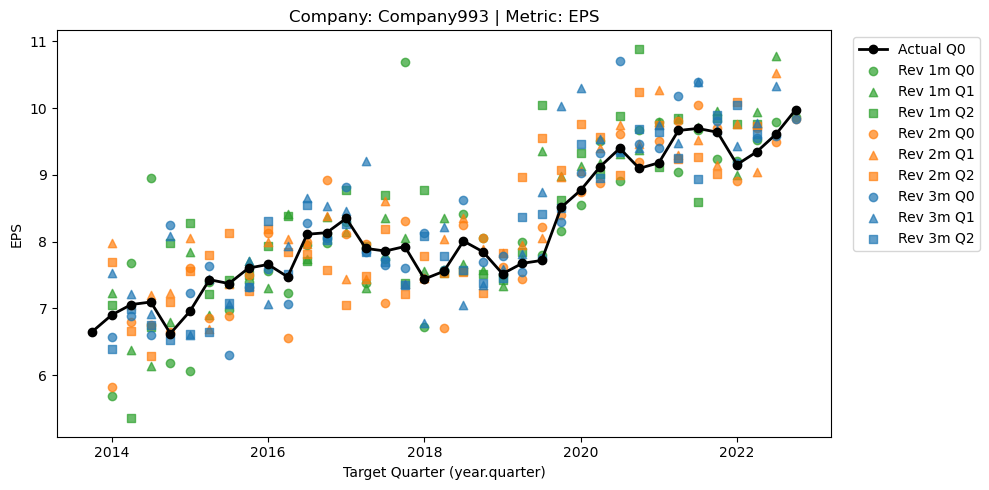

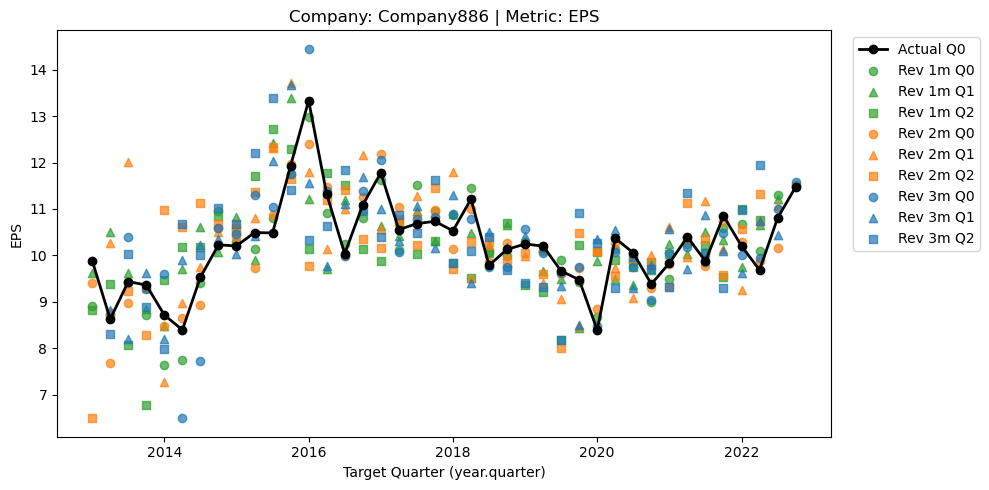

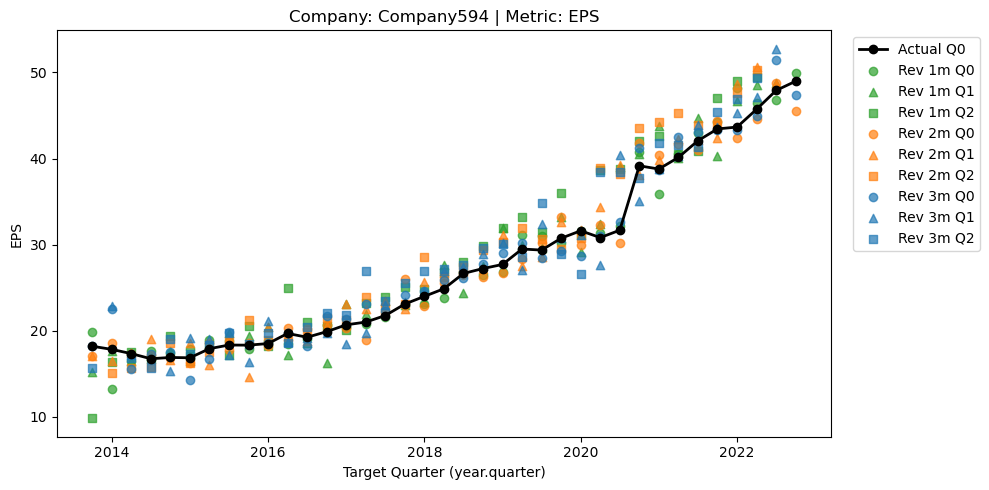

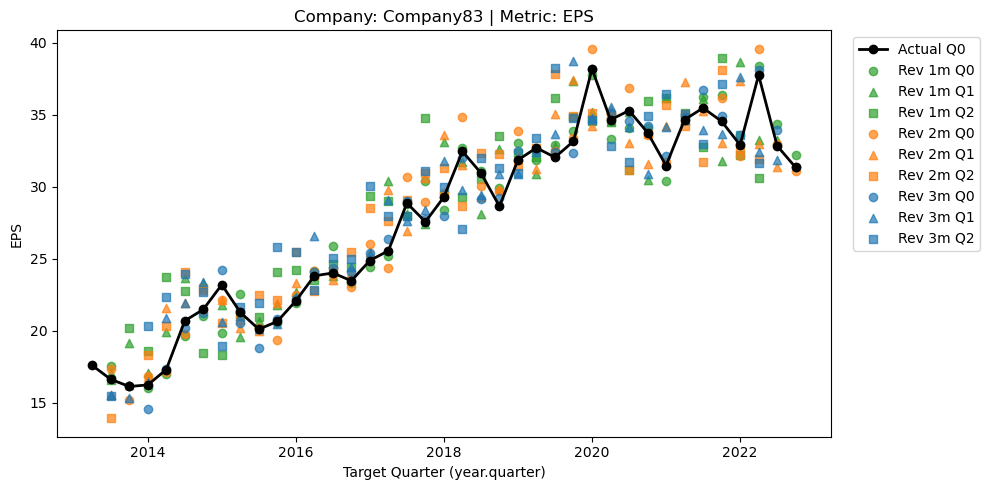

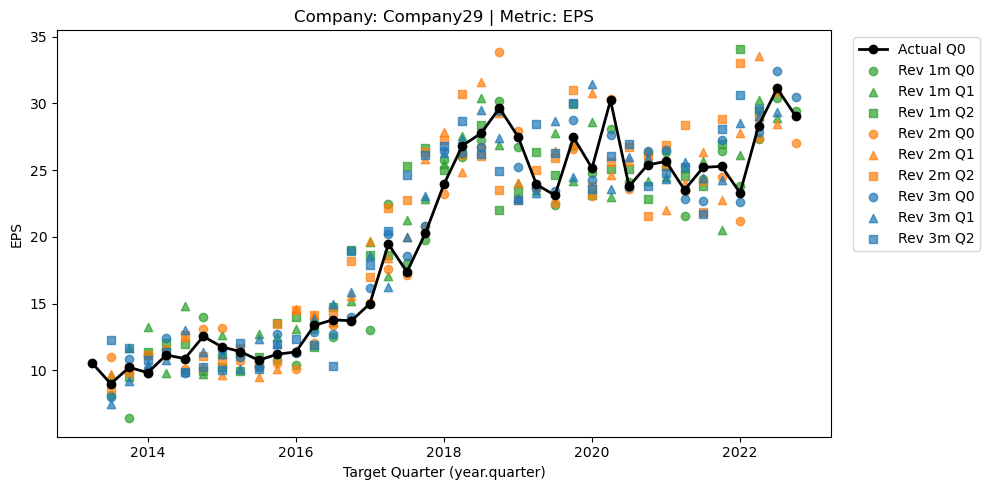

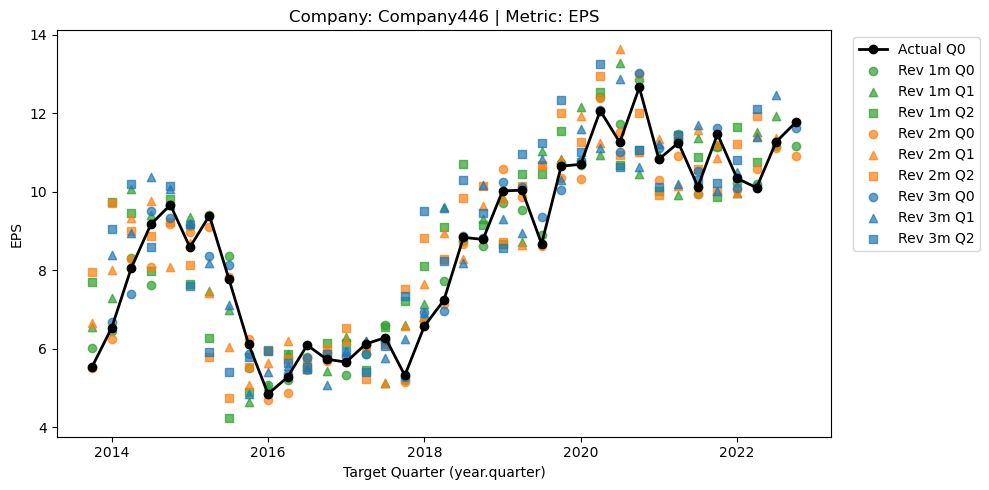

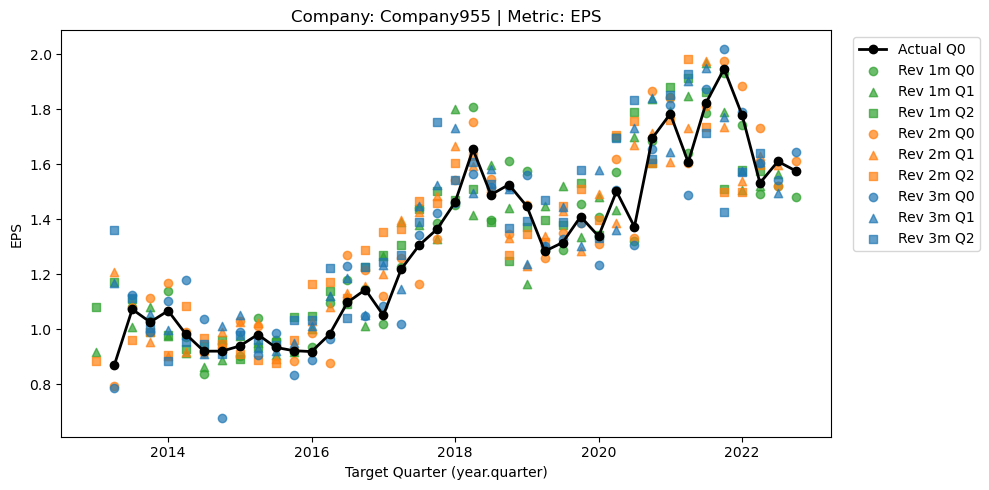

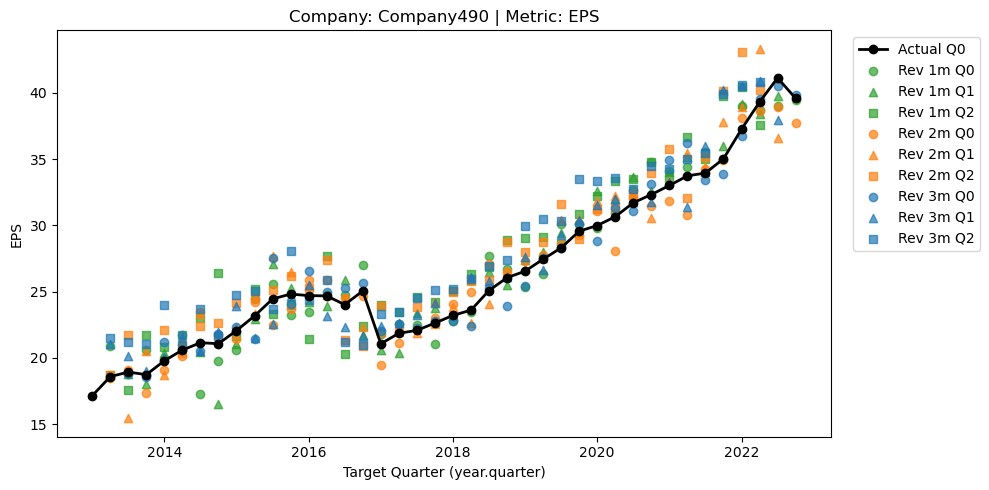

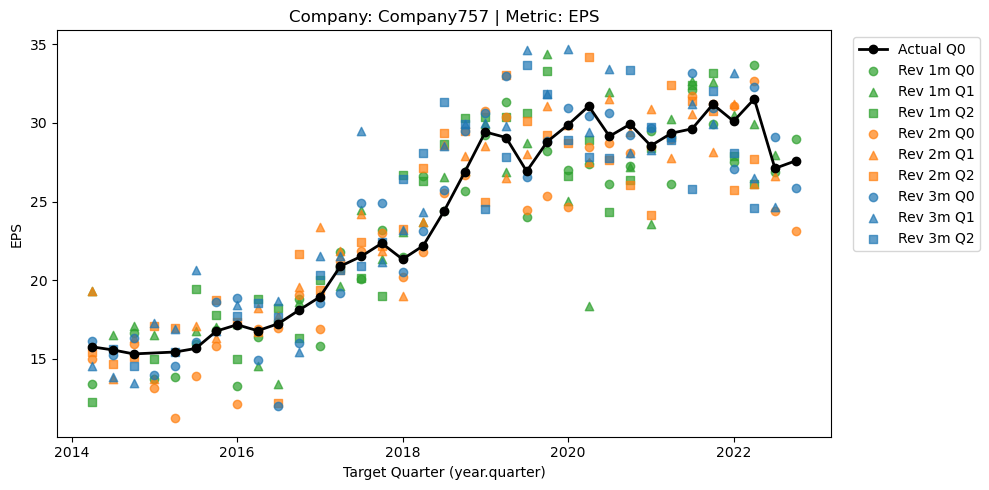

In [10]:
import numpy as np
import importlib
import support_functions             
importlib.reload(support_functions) 
from support_functions import visualize_random_companies

# ────────────────────────────────────────────────────────────────
# Build the quarter_ends_map right here
start_date   = pd.Timestamp("2013-01-01")
end_date     = pd.Timestamp("2023-01-01")
trading_days = pd.date_range(start_date, end_date, freq='B')
quarter_ends = trading_days.to_series().groupby(trading_days.to_period("Q")).last().values
quarter_ends = pd.to_datetime(quarter_ends)

quarter_ends_map = {
    f"Q{d.quarter} {d.year}": d
    for d in quarter_ends
}

# ────────────────────────────────────────────────────────────────
# Inject into *this* function object
visualize_random_companies._quarter_ends_map = quarter_ends_map

metrics = ["EBITDA", "Stock Price", "EPS"]

for metric in metrics:
    visualize_random_companies(df, metric=metric, m=10)

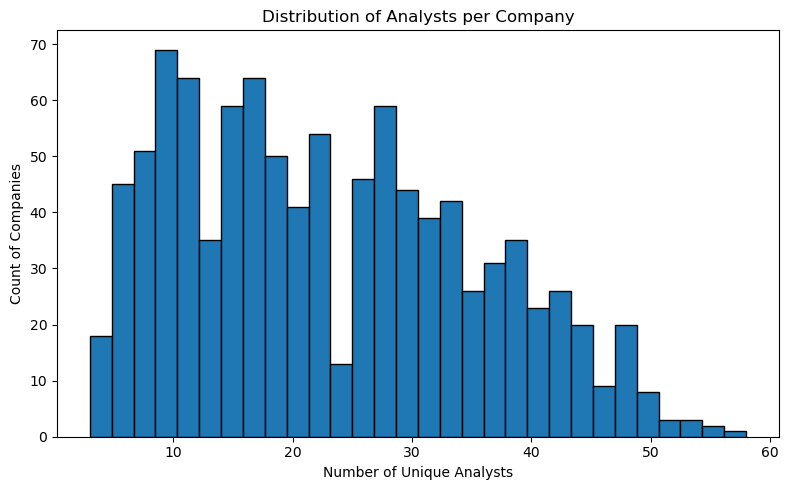

Company
Company1       27
Company10      12
Company100     32
Company1000    22
Company101     13
               ..
Company995     18
Company996     17
Company997     29
Company998     55
Company999     30
Name: Analyst, Length: 1000, dtype: int64

In [11]:
from support_functions import plot_analyst_coverage_hist
plot_analyst_coverage_hist(df)